# **PROJET 10: Détectez des faux billets avec Python**

Objectif du projet: Construire un algorithme capable de différencier automatiquement les vrais des faux billets à partir de leurs caractéristiques géométriques

### Méthodologie
L’objectif de ce projet est de mettre en place un algorithme de machine learning qui soit capable de différencier automatiquement les vrais des faux billets à partir des caractéristiques géométriques de ces billets.

Pour y parvenir nous allons utiliser deux méthode de classification: la régression logistique et le K mean; Une régression linéaire sera nécessaire pour le traitement des données manquantes; Les analyses seront faites dans le langage python

#### Import des librairies nécessaires et du fichier de données

In [1]:
## Importing required modules
import glob
import random
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import lightgbm as lgb
import geopandas as gpd
import plotly.express as px
from scipy.stats import skew
from unidecode import unidecode
import matplotlib.pyplot as plt
from fuzzywuzzy import process as fwp
import plotly.graph_objects as go
from shapely.geometry import Polygon
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
# from dataprep.eda import plot, plot_missing, plot_correlation, create_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importer le fichier billets 
billets = pd.read_csv('RESSOURCES/billets.csv',sep=";")
# billets = pd.read_csv('C:/Users/b301njc/Documents/P10/billets.csv',sep=";")
billets.info()
display(billets.head()) # (1074635, 76) # afficher les premières lignes d’un DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [3]:
# Nombre de vrais et faux billets
billets['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

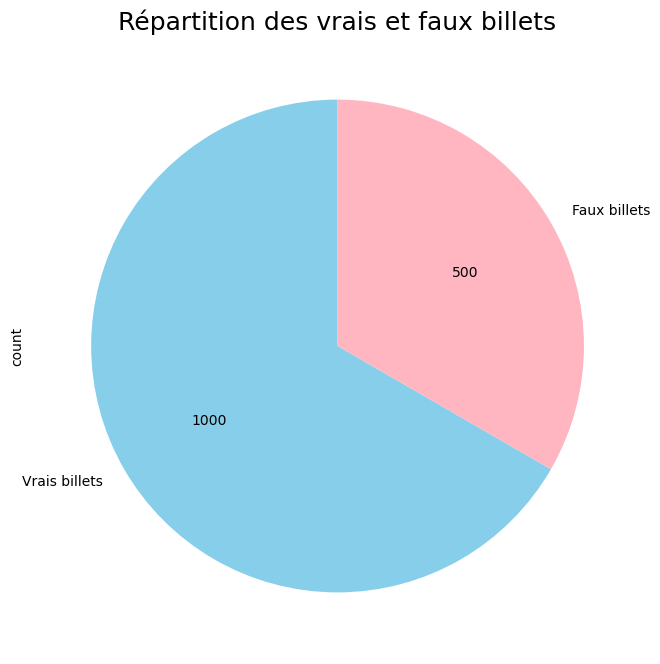

In [4]:
# Création d'une figure avec une taille spécifique
plt.figure(figsize=(12, 8))

# Définition des couleurs personnalisées pour les segments du pie chart
colors = ['skyblue', 'lightpink']  # Bleu ciel pour les vrais billets, orange pour les faux billets

# Fonction pour afficher les nombres absolus sur le pie chart
def absolute_value(val):
    total = sum(billets['is_genuine'].value_counts())
    return f'{int(val * total / 100)}'  # Convertir les pourcentages en nombres absolus

# Création du graphique circulaire (pie chart) pour la répartition des billets
billets['is_genuine'].value_counts().plot(kind="pie", autopct=absolute_value, 
                                          labels=["Vrais billets", "Faux billets"], startangle=90,
                                          colors=colors)  # Utilisation des couleurs personnalisées

# Ajout d'un titre au graphique
plt.title("Répartition des vrais et faux billets", fontsize=18)

# Affichage du graphique
plt.show()

In [5]:
# Valeurs uniques de chaque colonne
billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [6]:
# Vérification des statistiques des colonnes
billets.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

### Liens entre les Variables

/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: The palette 

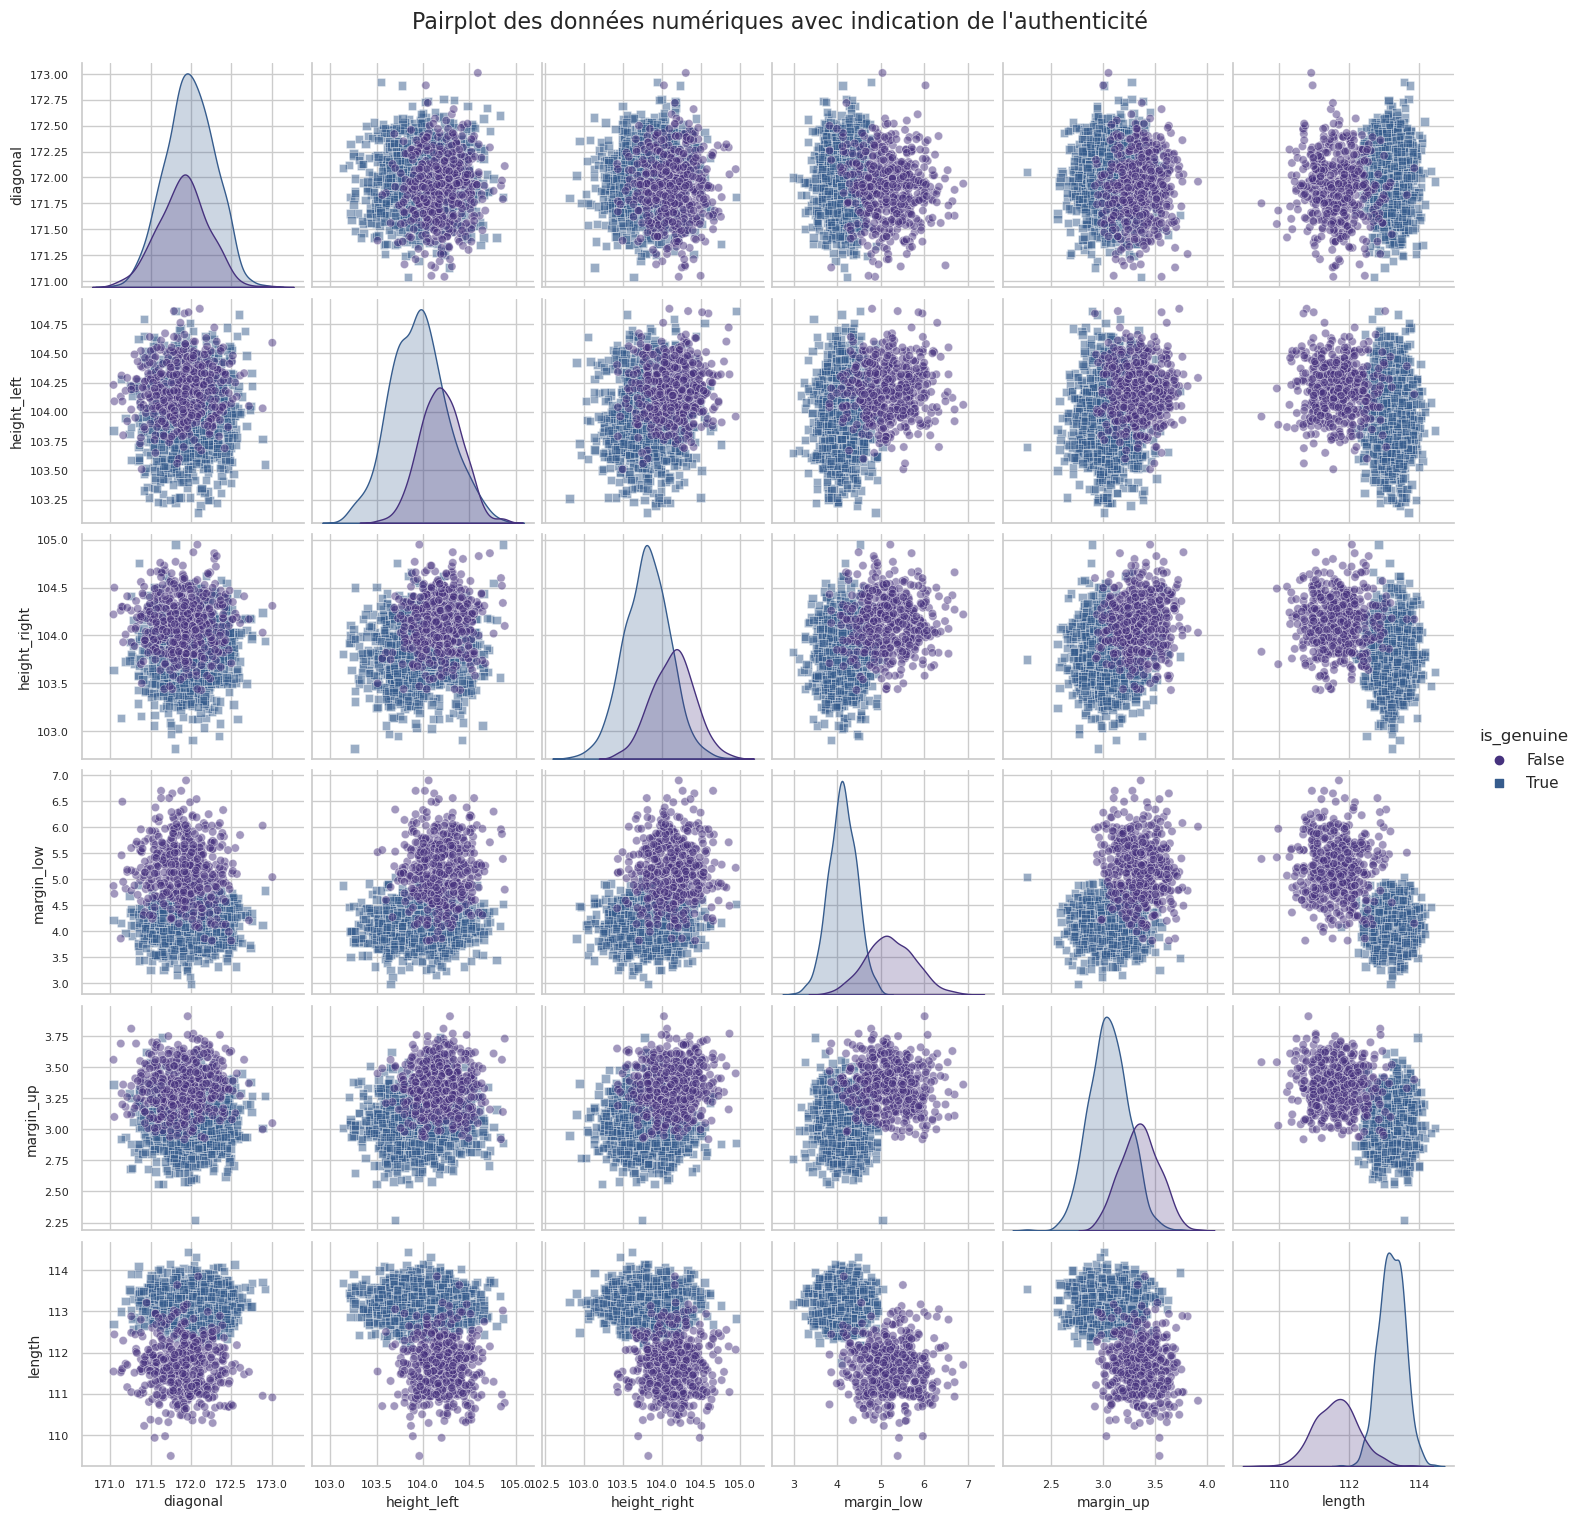

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Paramètres de style pour améliorer l'apparence
sns.set(style="whitegrid", palette="muted")

# Palette de couleurs pour la variable 'hue'
palette = sns.color_palette("viridis", as_cmap=False)

# Visualisation des données numériques
pairplot = sns.pairplot(billets, hue='is_genuine', palette=palette, markers=["o", "s"], plot_kws={'alpha':0.5})

# Ajouter un titre global
pairplot.fig.suptitle('Pairplot des données numériques avec indication de l\'authenticité', y=1.02, fontsize=16)

# Ajouter des légendes et des styles de texte
for ax in pairplot.axes.flat:
    # Ajouter des titres aux axes
    ax.set_title(ax.get_title(), fontsize=12, weight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)
    # Ajuster les ticks des axes
    ax.tick_params(axis='both', which='major', labelsize=8)

# Afficher la figure
plt.show()


### Explication de `sns.pairplot(billets, hue='is_genuine')`

#### Aperçu Général
La fonction `sns.pairplot` de Seaborn crée une matrice de graphiques en nuages de points pour chaque paire de variables numériques dans le DataFrame `billets`. La variable `hue='is_genuine'` colore les points selon que les billets sont vrais (`True`) ou faux (`False`). Cela permet de visualiser la distribution des billets vrais et faux par rapport à chaque paire de variables.

#### Détails de la Figure

1. **Diagonale Principale**:
   - Sur la diagonale principale, vous voyez des histogrammes ou des graphiques de densité pour chaque variable individuelle.
   - Par exemple, le graphique de densité pour `diagonal` montre la distribution de cette variable pour les vrais (en bleu) et les faux (en orange) billets.

2. **Graphiques en Nuages de Points**:
   - Chaque graphique en nuages de points en dehors de la diagonale compare deux variables différentes.
   - Par exemple, le graphique en haut à gauche compare `diagonal` avec `height_left`. Les points bleus représentent les vrais billets et les points orange représentent les faux billets.
   - Ces graphiques permettent de visualiser la relation entre deux variables et comment elles diffèrent entre les vrais et faux billets.

3. **Densité de Distribution**:
   - Sur chaque graphique de densité, vous pouvez voir comment les valeurs des variables se répartissent pour les vrais et faux billets.
   - Par exemple, pour la variable `margin_low`, les vrais billets semblent avoir une distribution différente des faux billets, ce qui pourrait être un indicateur important pour les différencier.

#### Interprétation
- **Relations Entre Variables**:
  - Les graphiques en nuages de points permettent d’identifier des corrélations potentielles entre les variables. Par exemple, il pourrait y avoir une corrélation entre `height_left` et `height_right`.
  - Si une relation linéaire ou non linéaire est présente, elle sera visible dans ces graphiques.

- **Séparation des Vrais et Faux Billets**:
  - Les couleurs des points (bleu pour les vrais, orange pour les faux) montrent comment les vrais et faux billets se distribuent par rapport à chaque paire de variables.
  - Par exemple, pour certaines paires de variables, les vrais et faux billets peuvent former des clusters distincts, ce qui peut aider à les séparer facilement en utilisant des techniques de classification.

- **Distribution Individuelle des Variables**:
  - Les graphiques de densité sur la diagonale montrent la distribution individuelle de chaque variable pour les vrais et faux billets.
  - Des différences significatives dans ces distributions peuvent indiquer que certaines variables sont de bons indicateurs pour distinguer les vrais et faux billets.

#### Exemple de Lecture d’un Graphique Spécifique
Prenons par exemple le graphique comparant `height_left` et `height_right` (deuxième rangée, troisième colonne) :
- **Vrais Billets** (points bleus) :
  - Ils semblent former un cluster serré, indiquant une relation plus cohérente entre `height_left` et `height_right`.
- **Faux Billets** (points orange) :
  - Ils sont plus dispersés, ce qui peut indiquer une incohérence dans ces dimensions pour les faux billets.

En résumé, le `pairplot` est un outil puissant pour explorer visuellement les relations entre les variables et pour identifier des patterns distincts qui peuvent aider à différencier les classes dans vos données, comme les vrais et faux billets dans ce cas.

## Matrice des corellations linéaires de pearson

In [8]:
billets_pearson = billets.corr(method='pearson')

billets_pearson.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_4636/52028688.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X[col], y=billets["margin_low"], ax=ax, palette=palette, alpha=0.6)
/tmp/ipykernel_4636/52028688.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X[col], y=billets["margin_low"], ax=ax, palette=palette, alpha=0.6)
/tmp/ipykernel_4636/52028688.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X[col], y=billets["margin_low"], ax=ax, palette=palette, alpha=0.6)
/tmp/ipykernel_4636/52028688.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X[col], y=billets["margin_low"], ax=ax, palette=palette, alpha=0.6)
/tmp/ipykernel_4636/52028688.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X[col], y=billets["margin_low"], ax=ax, palette=palette, alpha=

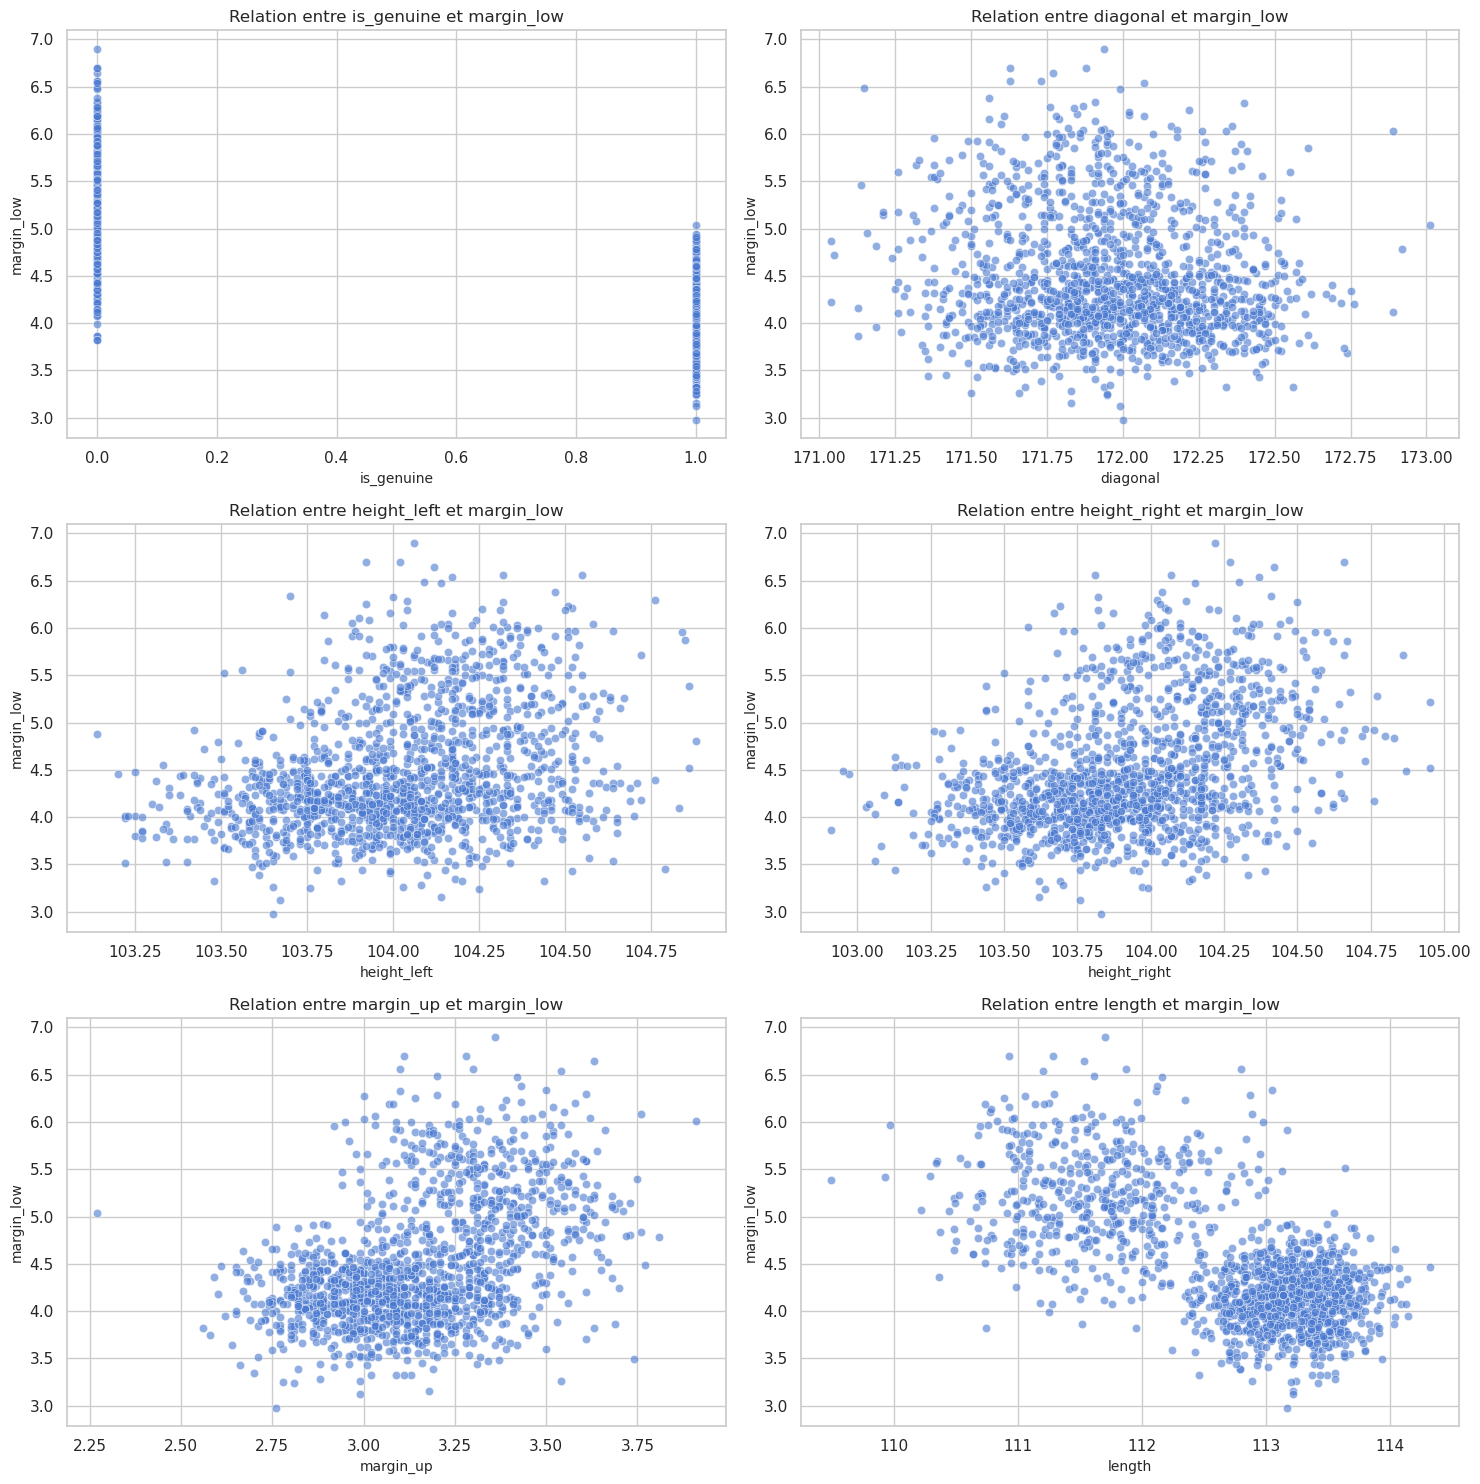

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppression de la variable "margin_low" pour obtenir les variables explicatives
X = billets.drop("margin_low", axis=1)

# Paramètres de style pour améliorer l'apparence
sns.set(style="whitegrid", palette="muted")

# Configuration de la figure pour afficher des graphiques côte à côte
num_cols = 2
num_rows = (len(X.columns) + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Palette de couleurs
palette = sns.color_palette("coolwarm", as_cmap=False)

# Parcours des colonnes et affichage des nuages de points
for i, col in enumerate(X.columns):
    row = i // num_cols
    col_idx = i % num_cols
    ax = axes[row, col_idx]
    sns.scatterplot(x=X[col], y=billets["margin_low"], ax=ax, palette=palette, alpha=0.6)
    ax.set_title(f"Relation entre {col} et margin_low", fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("margin_low", fontsize=10)

# Supprimer les axes vides si le nombre de graphiques est impair
if len(X.columns) % num_cols != 0:
    fig.delaxes(axes[num_rows-1, num_cols-1])

# Ajustement des espaces entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure
plt.show()


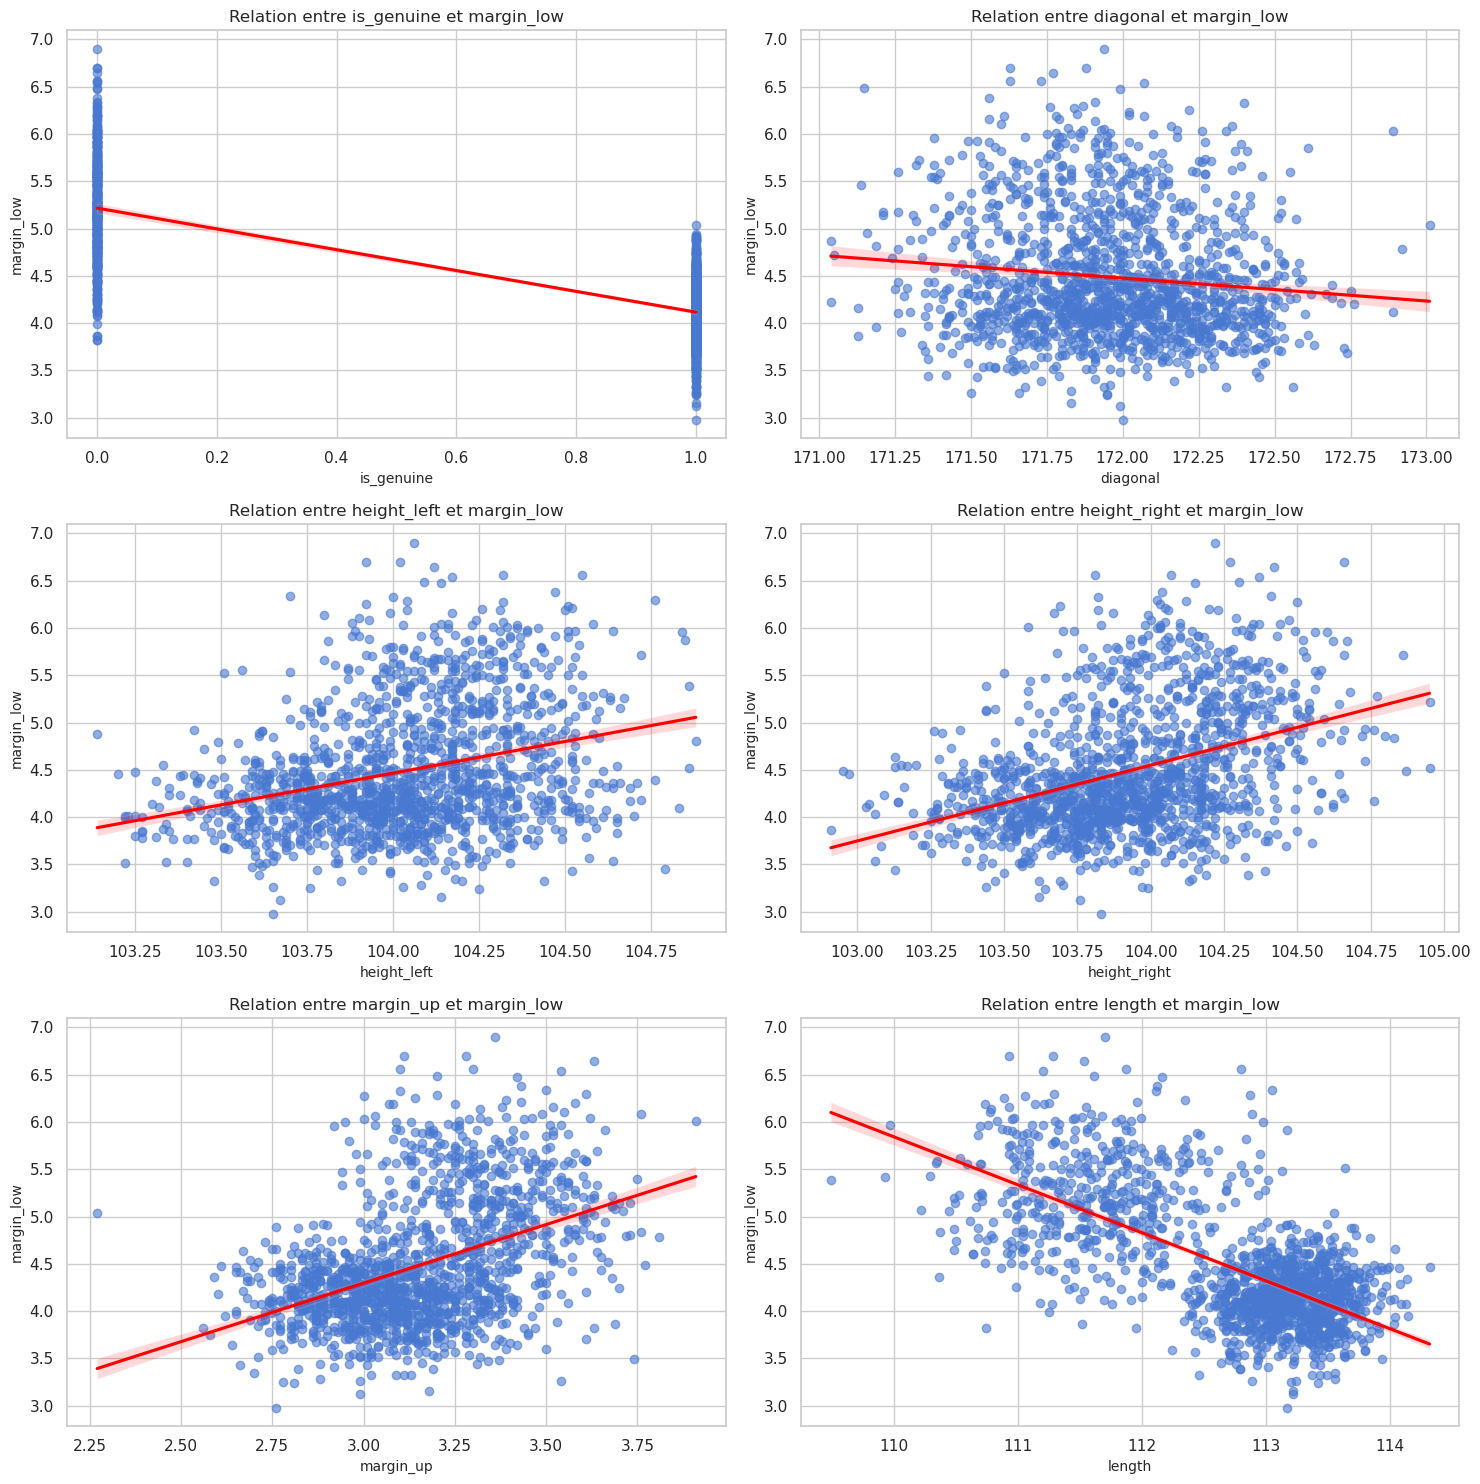

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppression de la variable "margin_low" pour obtenir les variables explicatives
X = billets.drop("margin_low", axis=1)

# Paramètres de style pour améliorer l'apparence
sns.set(style="whitegrid", palette="muted")

# Configuration de la figure pour afficher des graphiques côte à côte
num_cols = 2
num_rows = (len(X.columns) + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Palette de couleurs
palette = sns.color_palette("coolwarm", as_cmap=False)

# Parcours des colonnes et affichage des nuages de points avec lignes de régression
for i, col in enumerate(X.columns):
    row = i // num_cols
    col_idx = i % num_cols
    ax = axes[row, col_idx]
    sns.regplot(x=X[col], y=billets["margin_low"], ax=ax, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    ax.set_title(f"Relation entre {col} et margin_low", fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("margin_low", fontsize=10)

# Supprimer les axes vides si le nombre de graphiques est impair
if len(X.columns) % num_cols != 0:
    fig.delaxes(axes[num_rows-1, num_cols-1])

# Ajustement des espaces entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure
plt.show()

#### Exploration des données

In [12]:
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [14]:
# Recherche des valeurs dupliquées
print('Valeurs dupliquées : ', billets.duplicated().sum())

Valeurs dupliquées :  0


In [15]:
billets.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


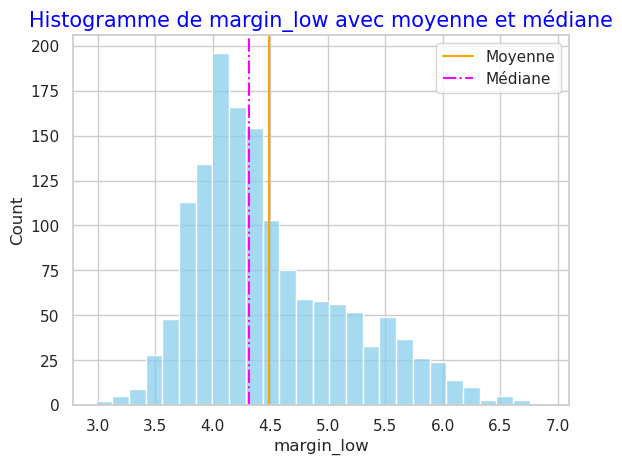

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul de la moyenne et de la médiane
moyenne = billets['margin_low'].mean()
médiane = billets['margin_low'].median()

# Création de l'histogramme
sns.histplot(data=billets, x='margin_low', color='skyblue', edgecolor='white')

# Ajout de la ligne de la moyenne
plt.axvline(moyenne, color='orange', linestyle='-')

# Ajout de la ligne de la médiane
plt.axvline(médiane, color='magenta', linestyle='-.')

# Ajout de la légende
plt.legend({'Moyenne': moyenne, 'Médiane': médiane})

# Ajout du titre
plt.title(label='Histogramme de margin_low avec moyenne et médiane', fontsize=15, color='blue')

# Affichage du graphique
plt.show()

Cette figure représente la distribution de la variable `margin_low` dans l'ensemble de données de billets. Voici une explication détaillée de ce que montre ce graphique :

1. **Histogramme de `margin_low`** :
   - Les barres bleues représentent le nombre de billets pour chaque intervalle de valeurs de `margin_low`.
   - L'axe horizontal (`x-axis`) montre les différentes valeurs de `margin_low`.
   - L'axe vertical (`y-axis`) indique le nombre de billets correspondant à chaque intervalle de valeurs.

2. **Ligne de la moyenne** :
   - La ligne orange verticale représente la moyenne de `margin_low`.
   - La moyenne est une mesure de tendance centrale qui indique la valeur moyenne de `margin_low` pour l'ensemble des billets.
   - Sur ce graphique, la moyenne se situe à environ 4.5.

3. **Ligne de la médiane** :
   - La ligne magenta en pointillés représente la médiane de `margin_low`.
   - La médiane est une autre mesure de tendance centrale qui indique la valeur au milieu de la distribution de `margin_low`. C'est la valeur pour laquelle la moitié des billets a une valeur inférieure et l'autre moitié a une valeur supérieure.
   - Sur ce graphique, la médiane se situe également autour de 4.5, légèrement à gauche de la moyenne.

4. **Légende** :
   - La légende en haut à droite indique les couleurs et styles de lignes utilisés pour représenter la moyenne et la médiane.
   - La ligne orange est étiquetée comme "Moyenne" et la ligne magenta en pointillés est étiquetée comme "Médiane".

5. **Titre du graphique** :
   - Le titre du graphique est "Représentation graphique avec moyenne et médiane".
   - Le titre est en bleu, ce qui le rend bien visible sur le graphique.

### Analyse Interprétation
- **Symétrie et Distribution** : Le graphique montre que la distribution de `margin_low` est légèrement asymétrique vers la droite (positivement asymétrique). La majorité des valeurs se concentrent autour de 4.0 à 4.5.
- **Comparaison Moyenne vs Médiane** : La proximité entre la moyenne et la médiane indique que la distribution est assez symétrique, bien que la queue à droite (plus longue) suggère une légère asymétrie positive.
- **Densité des Données** : Le pic de la distribution indique qu'il y a une concentration élevée de billets avec des valeurs de `margin_low` autour de 4.0 à 4.5.

En résumé, ce graphique fournit une visualisation claire de la distribution des valeurs de `margin_low`, avec des indications précises sur la moyenne et la médiane, aidant à comprendre la tendance centrale et la dispersion des données.

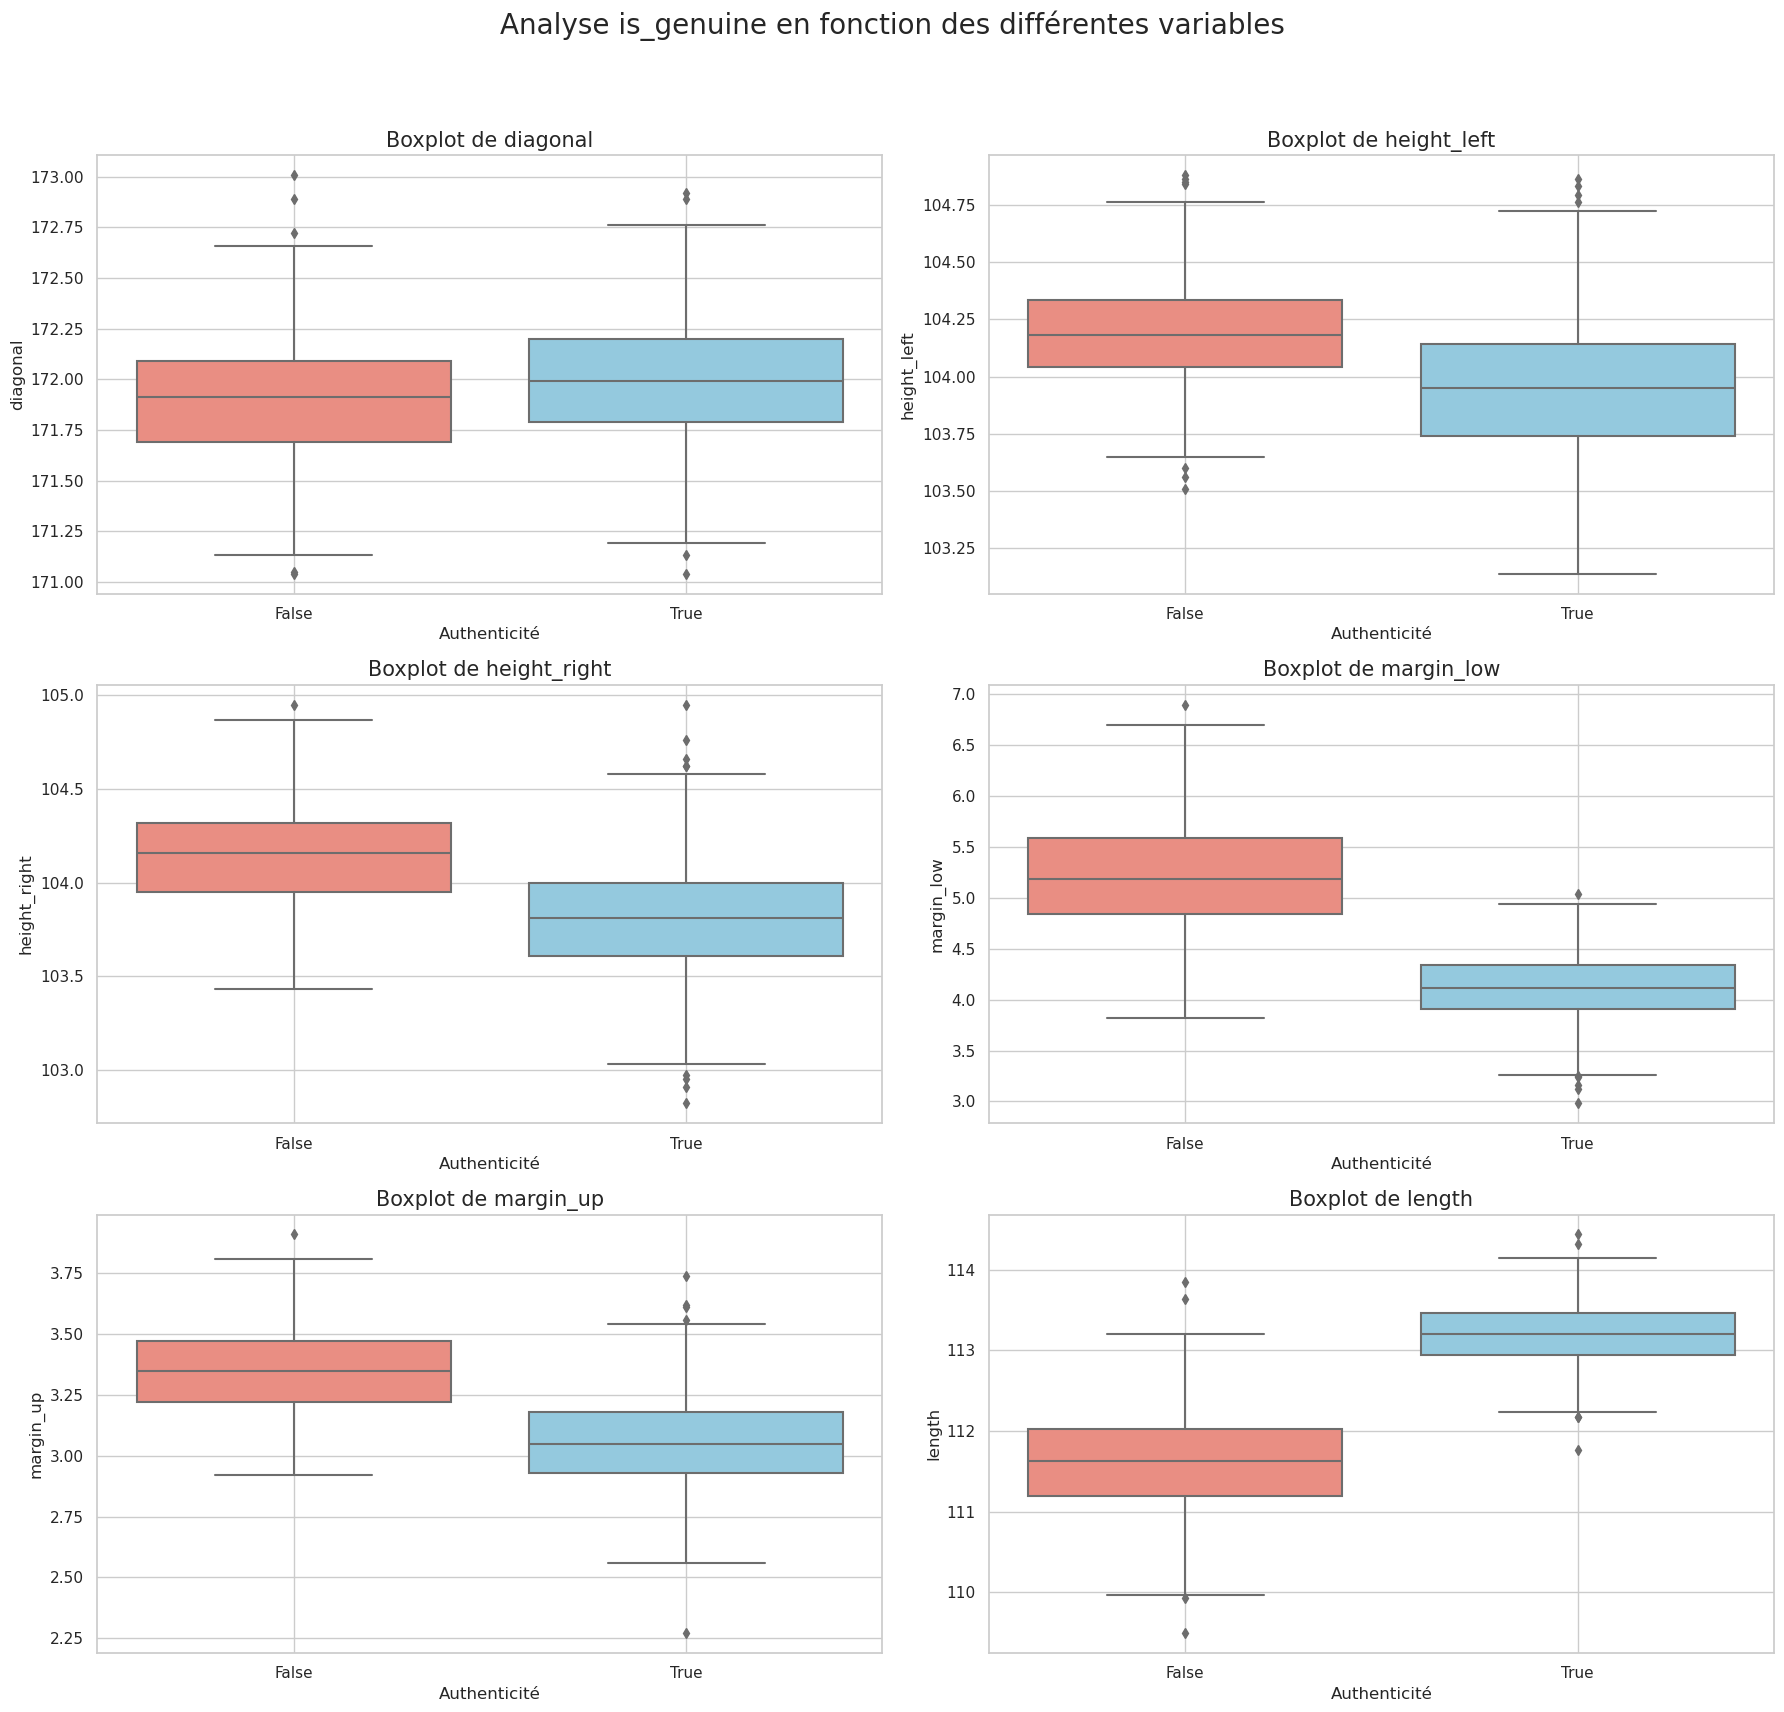

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définition des couleurs personnalisées pour les vrais et faux billets
custom_palette = {True: "skyblue", False: "salmon"}

# Création de la figure avec des sous-graphiques
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Parcours des sous-graphiques pour tracer les boxplots avec des couleurs personnalisées
for i in range(3):
    for j in range(2):
        variable = billets.columns[1:][2 * i + j]
        sns.boxplot(ax=axes[i, j], 
                    data=billets, 
                    x='is_genuine', 
                    y=variable,
                    palette=custom_palette)
        axes[i, j].set_title(f'Boxplot de {variable}', fontsize=15)
        axes[i, j].set_xlabel('Authenticité', fontsize=12)
        axes[i, j].set_ylabel(variable, fontsize=12)
        axes[i, j].grid(True)

# Ajout d'un titre général à la figure
plt.suptitle('Analyse is_genuine en fonction des différentes variables', fontsize=20)

# Réduire les espaces inutiles
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Affichage de la figure
plt.show()


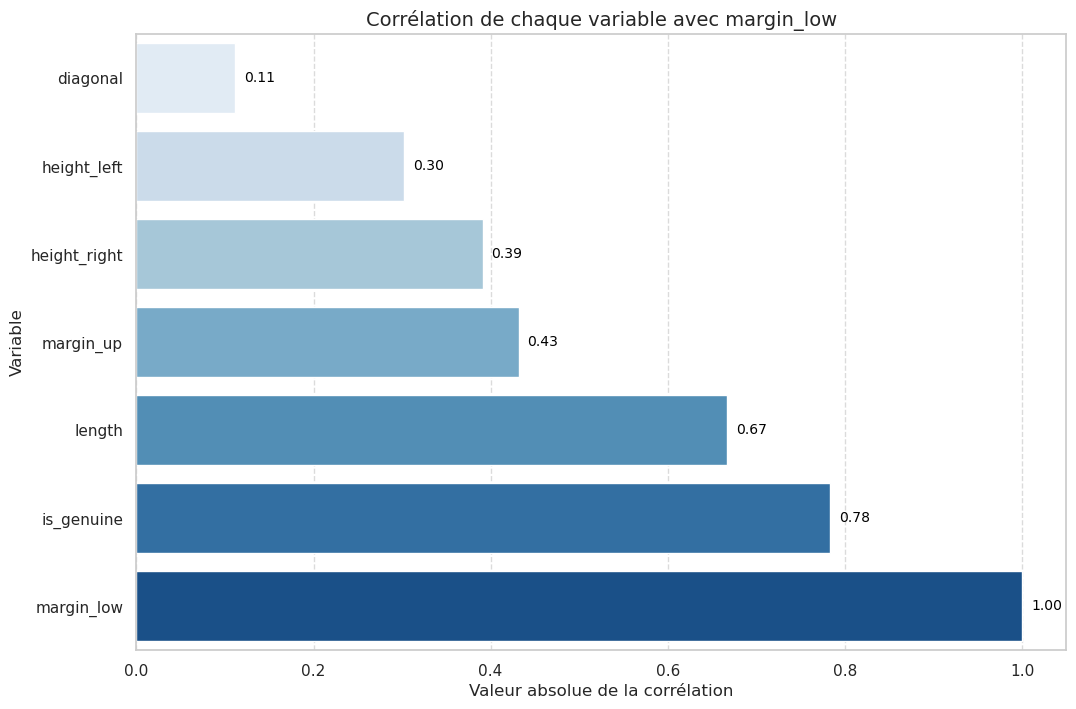

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul de la corrélation entre chaque variable et la variable cible (en valeur absolue)
correlations = abs(billets.corr()["margin_low"]).sort_values(ascending=False)

# Inversion de l'ordre des corrélations pour obtenir le bleu foncé pour les valeurs importantes
correlations = correlations[::-1]

# Représentation graphique des corrélations
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations.values, y=correlations.index, palette="Blues")

# Ajout de bordures aux barres et annotations
for i, v in enumerate(correlations.values):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center', fontsize=10, color='black')

plt.xlabel("Valeur absolue de la corrélation", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.title("Corrélation de chaque variable avec margin_low", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Fond de la figure en blanc
plt.gca().patch.set_facecolor('white')

plt.show()


# Regression linéaire
On va estimer un modèle de régression avec plusieurs variables explicatives et une variable dépendante qui est celle qui contient les valeurs manquantes margin_low ou Y. On va calculer un modèle prédictif avec comme variable à prédire Y. Ensuite on applique ce modèle pour estime les différentes valeurs manquantes de Y.

In [18]:
# Pour la regression lineaire:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [21]:
# Suppression desdonnées manquantes :
# Reg_Lin_Train_df = billets.dropna()
df_Train_reg_lin = billets.dropna()
display(df_Train_reg_lin.head())
df_Train_reg_lin.shape

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

(1463, 7)

In [22]:
#Création d'n dataset comprenant les valeurs manquantes sur la variable margin_low
# Reg_Lin_Test_df = billets[billets.isnull().any(axis=1)]
df_Test_reg_lin = billets[billets.isnull().any(axis=1)]
display(df_Test_reg_lin.head()) 
df_Test_reg_lin.shape

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72         True    171.94       103.89        103.45         NaN       3.25   
99         True    171.93       104.07        104.18         NaN       3.14   
151        True    172.07       103.80        104.38         NaN       3.02   
197        True    171.45       103.66        103.80         NaN       3.62   
241        True    171.83       104.14        104.06         NaN       3.02   

     length  
72   112.79  
99   113.08  
151  112.93  
197  113.27  
241  112.36

(37, 7)

Forte corrélation de notre variable qualitative avec margin_low mais aussi forte corélation avec length

### 2. Séparation des données avec et sans valeurs manquantes

 Nous séparons les données en deux ensembles : un avec les valeurs non manquantes dans margin_low et un autre avec les valeurs manquantes.

In [23]:
# Séparation des données avec et sans valeurs manquantes dans 'margin_low'
billets_non_na = billets.dropna(subset=['margin_low'])
billets_na = billets[billets['margin_low'].isna()]

### 3. Séparation des variables explicatives et de la variable cible 
Commentaire : Nous définissons X comme les variables explicatives en excluant margin_low et is_genuine, et y comme la variable cible margin_low.

In [24]:
# Séparation des variables explicatives et de la variable cible pour les données non NA
X = billets_non_na.drop(columns=['margin_low', 'is_genuine'])
y = billets_non_na['margin_low']

### 4. Division des données en ensembles d'entraînement et de test
Commentaire : Nous divisons les données en ensembles d'entraînement (80%) et de test (20%).

In [25]:
# Division des données en ensembles d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5. Modèle de Régression Linéaire Simple
Nous entraînons et évaluons un modèle de régression linéaire simple en utilisant length comme seule variable explicative.

In [26]:
# Sélection d'une seule variable explicative
X_train_simple = X_train[['length']]
X_test_simple = X_test[['length']]

X_train_simple = sm.add_constant(X_train_simple)  # Ajout d'une constante pour l'interception
X_test_simple = sm.add_constant(X_test_simple)  # Ajout d'une constante pour l'interception

# Entraînement du modèle
# model_lin = LinearRegression().fit(X_train_simple, y_train)
model_lin = sm.OLS(y_train, X_train_simple).fit()
print(model_lin.summary())
# Prédiction sur l'ensemble de test
y_pred_simple = model_lin.predict(X_test_simple)

# Évaluation du modèle
mse_simple = mean_squared_error(y_test, y_pred_simple)
r2_simple = r2_score(y_test, y_pred_simple)
print("Régression Linéaire Simple:")
print("MSE:", mse_simple)
print("R²:", r2_simple)

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     874.1
Date:                Fri, 05 Jul 2024   Prob (F-statistic):          7.17e-144
Time:                        03:14:44   Log-Likelihood:                -859.74
No. Observations:                1170   AIC:                             1723.
Df Residuals:                    1168   BIC:                             1734.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.7050      1.902     31.922      0.0



### Résultats de la Régression Linéaire (OLS)

**Variable dépendante:** `margin_low`

- **R-squared (R²):** 0.428
  - Cela signifie que le modèle explique environ 42.8% de la variance de `margin_low`. C'est une mesure de la qualité de l'ajustement du modèle. Un R² de 0.428 indique que le modèle a une capacité modérée à expliquer les variations de la variable dépendante.

- **Adjusted R-squared:** 0.428
  - Ajusté pour le nombre de prédicteurs dans le modèle, ce qui le rend plus précis pour comparer des modèles avec des nombres de prédicteurs différents. Dans ce cas, c'est identique à R² car il n'y a qu'un seul prédicteur.

- **F-statistic:** 874.1
  - L'F-statistic teste si le modèle globalement est significatif. Une valeur élevée indique que le modèle est significatif.

- **Prob (F-statistic):** 7.17e-144
  - La probabilité associée à l'F-statistic est extrêmement faible, ce qui signifie que le modèle est statistiquement significatif.

- **Log-Likelihood:** -859.74
  - Une mesure de la probabilité du modèle étant correct. Plus la valeur est élevée, mieux c'est, mais elle est principalement utilisée pour comparer des modèles.

- **AIC (Akaike Information Criterion):** 1723
  - Une mesure de la qualité du modèle, plus faible est généralement mieux.

- **BIC (Bayesian Information Criterion):** 1734
  - Similaire à l'AIC mais pénalise plus les modèles avec plus de paramètres.

### Coefficients du Modèle

- **const (Intercept):** 60.7050
  - Lorsque la `length` est 0, la valeur prédite de `margin_low` est 60.7050.

- **length:** -0.4990
  - Pour chaque unité supplémentaire de `length`, `margin_low` diminue de 0.4990 unités en moyenne. Ce coefficient est statistiquement significatif avec une p-value de 0.000.

### Test de Normalité et d'Autocorrélation

- **Omnibus:** 86.499
  - Un test pour la normalité des résidus. Une valeur élevée suggère une déviation de la normalité.

- **Prob(Omnibus):** 0.000
  - La probabilité associée à l'Omnibus est très faible, indiquant que les résidus ne sont pas normalement distribués.

- **Jarque-Bera (JB):** 118.103
  - Un autre test pour la normalité. Une valeur élevée indique une déviation de la normalité.

- **Prob(JB):** 2.26e-26
  - La probabilité associée au JB est extrêmement faible, confirmant que les résidus ne sont pas normalement distribués.

- **Skew:** 0.613
  - Indique l'asymétrie des résidus. Une valeur de 0 serait parfaitement symétrique.

- **Kurtosis:** 3.958
  - Indique la "pointedness" des résidus. Une valeur de 3 serait normale.

- **Durbin-Watson:** 1.970
  - Teste l'autocorrélation des résidus. Une valeur proche de 2 indique qu'il n'y a pas d'autocorrélation.

### Note sur la Multicolinéarité

- **Condition Number:** 1.45e+04
  - Un nombre élevé peut indiquer une forte multicolinéarité ou d'autres problèmes numériques. Dans ce cas, la valeur est relativement élevée, suggérant que cela pourrait être un problème à examiner plus en profondeur.

### Performance du Modèle

- **Mean Squared Error (MSE):** 0.20501721543154167
  - Mesure la moyenne des carrés des erreurs, indiquant combien les prédictions du modèle diffèrent des valeurs réelles.

- **R²:** 0.5136070700267941
  - Un coefficient de détermination pour un autre jeu de données, montrant la proportion de la variance de la variable dépendante expliquée par le modèle. Un R² de 0.514 indique que le modèle est modérément bon pour expliquer la variance.

### Conclusion

Le modèle de régression linéaire simple montre une relation statistiquement significative entre `length` et `margin_low`, expliquant environ 42.8% de la variance de `margin_low`. Cependant, il y a des indications que les résidus ne sont pas normalement distribués et qu'il pourrait y avoir des problèmes de multicolinéarité. Le modèle a une performance modérée avec un R² de 0.514 sur un jeu de test séparé.

### 6. Prédiction des valeurs manquantes dans margin_low (Régression Linéaire Simple)
Nous utilisons le modèle simple pour prédire les valeurs manquantes de margin_low.

In [27]:
# Prédiction des valeurs manquantes dans 'margin_low'
# billets_na['margin_low'] = model_lin.predict(billets_na[['length']])
# Prédiction des valeurs manquantes dans 'margin_low'
# billets_na.loc[:, 'margin_low'] = model_lin.predict(billets_na[['length']])
billets_na.loc[:, 'margin_low'] = model_lin.predict(sm.add_constant(billets_na[['length']]))

### 7. Modèle de Régression Linéaire Multiple
Nous entraînons et évaluons un modèle de régression linéaire multiple en utilisant toutes les variables explicatives.

In [28]:
# Modèle de Régression Linéaire Multiple avec statsmodels
X_train_mult = sm.add_constant(X_train)  # Ajout d'une constante pour l'interception
X_test_mult = sm.add_constant(X_test)  # Ajout d'une constante pour l'interception

# Entraînement du modèle multiple
# Ajuster le modèle de régression multiple
model_mult = sm.OLS(y_train, X_train_mult).fit()

# Afficher les résultats de la régression multiple
print(model_mult.summary())

# Prédiction sur l'ensemble de test
y_pred_mult = model_mult.predict(X_test_mult)
mse_mult = mean_squared_error(y_test, y_pred_mult)
r2_mult = r2_score(y_test, y_pred_mult)
print("Régression Linéaire Multiple:")
print("MSE:", mse_mult)
print("R²:", r2_mult)

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     198.7
Date:                Fri, 05 Jul 2024   Prob (F-statistic):          3.54e-153
Time:                        03:14:58   Log-Likelihood:                -825.58
No. Observations:                1170   AIC:                             1663.
Df Residuals:                    1164   BIC:                             1694.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           20.3960     11.266      1.810   

### Résultats de la Régression Linéaire Multiple (OLS)

**Variable dépendante:** `margin_low`

- **R-squared (R²):** 0.460
  - Cela signifie que le modèle explique environ 46.0% de la variance de `margin_low`. C'est une mesure de la qualité de l'ajustement du modèle. Un R² de 0.460 indique que le modèle a une capacité modérée à expliquer les variations de la variable dépendante.

- **Adjusted R-squared:** 0.458
  - Ajusté pour le nombre de prédicteurs dans le modèle, ce qui le rend plus précis pour comparer des modèles avec des nombres de prédicteurs différents. Dans ce cas, il est très proche de R² car le nombre de prédicteurs est raisonnable.

- **F-statistic:** 198.7
  - L'F-statistic teste si le modèle globalement est significatif. Une valeur élevée indique que le modèle est significatif.

- **Prob (F-statistic):** 3.54e-153
  - La probabilité associée à l'F-statistic est extrêmement faible, ce qui signifie que le modèle est statistiquement significatif.

- **Log-Likelihood:** -825.58
  - Une mesure de la probabilité du modèle étant correct. Plus la valeur est élevée, mieux c'est, mais elle est principalement utilisée pour comparer des modèles.

- **AIC (Akaike Information Criterion):** 1663
  - Une mesure de la qualité du modèle, plus faible est généralement mieux.

- **BIC (Bayesian Information Criterion):** 1694
  - Similaire à l'AIC mais pénalise plus les modèles avec plus de paramètres.

### Coefficients du Modèle

- **const (Intercept):** 20.3960
  - Lorsque toutes les autres variables sont égales à zéro, la valeur prédite de `margin_low` est 20.3960. Ce coefficient n'est pas statistiquement significatif au seuil de 5% (p-value = 0.070).

- **diagonal:** -0.0872
  - Pour chaque unité supplémentaire de `diagonal`, `margin_low` diminue de 0.0872 unités en moyenne. Ce coefficient n'est pas statistiquement significatif au seuil de 5% (p-value = 0.071).

- **height_left:** 0.1547
  - Pour chaque unité supplémentaire de `height_left`, `margin_low` augmente de 0.1547 unités en moyenne. Ce coefficient est statistiquement significatif (p-value = 0.003).

- **height_right:** 0.2599
  - Pour chaque unité supplémentaire de `height_right`, `margin_low` augmente de 0.2599 unités en moyenne. Ce coefficient est statistiquement significatif (p-value = 0.000).

- **margin_up:** 0.2910
  - Pour chaque unité supplémentaire de `margin_up`, `margin_low` augmente de 0.2910 unités en moyenne. Ce coefficient est statistiquement significatif (p-value = 0.000).

- **length:** -0.3990
  - Pour chaque unité supplémentaire de `length`, `margin_low` diminue de 0.3990 unités en moyenne. Ce coefficient est statistiquement significatif (p-value = 0.000).

### Test de Normalité et d'Autocorrélation

- **Omnibus:** 64.246
  - Un test pour la normalité des résidus. Une valeur élevée suggère une déviation de la normalité.

- **Prob(Omnibus):** 0.000
  - La probabilité associée à l'Omnibus est très faible, indiquant que les résidus ne sont pas normalement distribués.

- **Jarque-Bera (JB):** 81.251
  - Un autre test pour la normalité. Une valeur élevée indique une déviation de la normalité.

- **Prob(JB):** 2.27e-18
  - La probabilité associée au JB est extrêmement faible, confirmant que les résidus ne sont pas normalement distribués.

- **Skew:** 0.521
  - Indique l'asymétrie des résidus. Une valeur de 0 serait parfaitement symétrique.

- **Kurtosis:** 3.761
  - Indique la "pointedness" des résidus. Une valeur de 3 serait normale.

- **Durbin-Watson:** 1.981
  - Teste l'autocorrélation des résidus. Une valeur proche de 2 indique qu'il n'y a pas d'autocorrélation.

### Note sur la Multicolinéarité

- **Condition Number:** 1.98e+05
  - Un nombre élevé peut indiquer une forte multicolinéarité ou d'autres problèmes numériques. Dans ce cas, la valeur est très élevée, suggérant qu'il pourrait y avoir des problèmes de multicolinéarité ou d'autres problèmes numériques.

### Performance du Modèle

- **Mean Squared Error (MSE):** 0.19144954947493303
  - Mesure la moyenne des carrés des erreurs, indiquant combien les prédictions du modèle diffèrent des valeurs réelles.

- **R²:** 0.5457956683532413
  - Un coefficient de détermination pour un autre jeu de données, montrant la proportion de la variance de la variable dépendante expliquée par le modèle. Un R² de 0.546 indique que le modèle est modérément bon pour expliquer la variance.

### Conclusion

Le modèle de régression linéaire multiple montre une relation statistiquement significative entre les prédicteurs (diagonal, height_left, height_right, margin_up, length) et `margin_low`, expliquant environ 46.0% de la variance de `margin_low`. Cependant, il y a des indications que les résidus ne sont pas normalement distribués et qu'il pourrait y avoir des problèmes de multicolinéarité. Le modèle a une performance modérée avec un R² de 0.546 sur un jeu de test séparé.

### Comparaison avec la Régression Linéaire Simple

- **R² du modèle simple:** 0.428
- **R² du modèle multiple:** 0.460

Le modèle multiple a une meilleure capacité à expliquer la variance de `margin_low` par rapport au modèle simple. Le R² ajusté est également plus élevé, indiquant que l'ajout de plusieurs prédicteurs améliore la précision du modèle. Cependant, le modèle multiple pourrait souffrir de problèmes de multicolinéarité, comme indiqué par le condition number élevé.

### 8. Prédiction des valeurs manquantes dans margin_low (Régression Linéaire Multiple)
Nous utilisons le modèle multiple pour prédire les valeurs manquantes de margin_low.

In [29]:
# billets_na['margin_low'] = model_mult.predict(billets_na.drop(columns=['margin_low', 'is_genuine']))
# Prédiction des valeurs manquantes dans 'margin_low' avec le modèle multiple
billets_na.loc[:, 'margin_low'] = model_mult.predict(sm.add_constant(billets_na.drop(columns=['margin_low', 'is_genuine'])))

### 9. Concaténation des données complètes
Nous combinons les données complètes avec les valeurs prédictes pour margin_low.

In [30]:
# Concaténation des données complètes
billets_complete = pd.concat([billets_non_na, billets_na])

### 10. Tests supplémentaires pour la Régression Linéaire Multiple
#### 10.1. Normalité des résidus
Nous vérifions la distribution des résidus pour tester la normalité.

/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


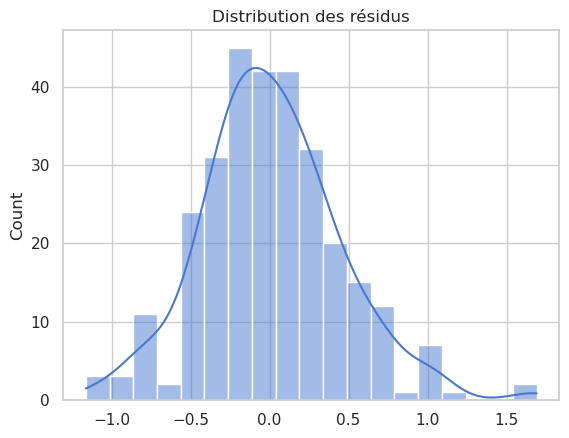

In [31]:
# Normalité des résidus
residuals_mult = y_test - y_pred_mult
sns.histplot(residuals_mult, kde=True)
plt.title('Distribution des résidus')
plt.show()

### Interprétation de la Figure de Normalité des Résidus

**Description de la Figure:**

Cette figure montre un histogramme des résidus du modèle de régression multiple avec une courbe de densité superposée. Les résidus sont les différences entre les valeurs observées et les valeurs prédites par le modèle.

**Analyse de la Normalité:**

L'objectif principal de cette figure est de vérifier si les résidus suivent une distribution normale, ce qui est une des hypothèses importantes de la régression linéaire.

#### Points Clés de l'Analyse:

1. **Forme de l'Histogramme:**
   - L'histogramme montre que la majorité des résidus sont centrés autour de zéro, ce qui est un bon signe.
   - La distribution semble relativement symétrique, mais il y a un léger décalage vers la droite, ce qui indique une légère asymétrie positive.

2. **Courbe de Densité:**
   - La courbe de densité superposée semble suivre une forme de cloche, semblable à une distribution normale.
   - Cependant, il y a des queues plus épaisses aux extrémités gauche et droite de la distribution, ce qui pourrait indiquer la présence de quelques valeurs aberrantes.

3. **Distribution des Résidus:**
   - La plupart des résidus se situent entre -0.5 et 0.5, ce qui indique que les erreurs de prédiction sont généralement faibles.
   - Il y a quelques résidus au-delà de 1 et en dessous de -1, mais ils sont relativement rares.

#### Conclusion:

- **Normalité Approximative:** Les résidus semblent suivre approximativement une distribution normale, bien qu'il y ait quelques petites déviations.
- **Valeurs Aberrantes:** La présence de valeurs aberrantes peut affecter la normalité des résidus. Il peut être utile de les examiner de plus près pour comprendre leur impact sur le modèle.
- **Validité du Modèle:** Si la distribution des résidus est proche de la normale, cela indique que les hypothèses de la régression linéaire sont en grande partie respectées. Cependant, il serait également judicieux de compléter cette analyse par des tests statistiques formels de normalité (par exemple, test de Shapiro-Wilk).

### Recommandations:

Pour une évaluation plus complète de la normalité des résidus, il est recommandé de:

1. **Effectuer des Tests Statistiques:** Utiliser des tests de normalité comme le test de Shapiro-Wilk ou le test de Kolmogorov-Smirnov.
2. **Examiner les Valeurs Aberrantes:** Identifier et analyser les valeurs aberrantes pour comprendre leur origine et leur impact.
3. **QQ-Plot:** Tracer un QQ-Plot (Quantile-Quantile Plot) pour une visualisation plus détaillée de la normalité des résidus.

Ces étapes supplémentaires fourniront une image plus claire de la distribution des résidus et aideront à valider les hypothèses du modèle de régression multiple.

#### 10.2. Homoscédasticité
Nous vérifions l'homoscédasticité des résidus.

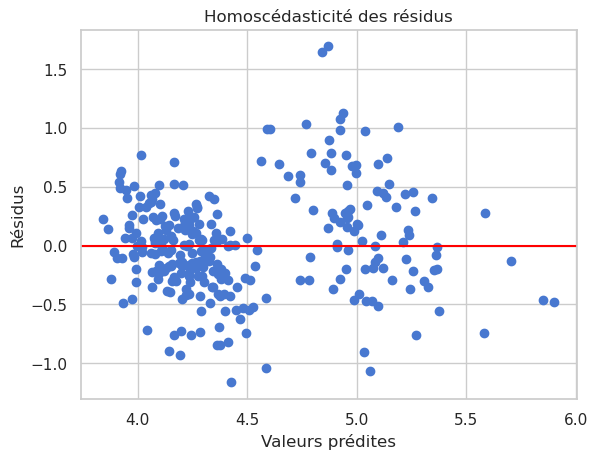

In [32]:
# Test d'homoscédasticité
# Homoscédasticité
plt.scatter(y_pred_mult, residuals_mult)
plt.axhline(y=0, color='red')

plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Homoscédasticité des résidus')
plt.show()

### Interprétation de la Figure de l'Homoscédasticité des Résidus

**Description de la Figure:**

Cette figure est un nuage de points représentant les résidus du modèle de régression multiple par rapport aux valeurs prédites. L'objectif est de vérifier l'homoscédasticité, c'est-à-dire que la variance des erreurs (ou résidus) est constante à travers toutes les valeurs des prédictions.

#### Points Clés de l'Analyse:

1. **Distribution des Résidus:**
   - Les résidus sont dispersés de manière assez uniforme autour de la ligne horizontale de zéro, ce qui est un bon signe.
   - Toutefois, on observe une concentration des résidus entre les valeurs prédites de 4.0 et 5.5, avec une distribution plus étalée au-dessus de 5.5.

2. **Absence de Structure Apparente:**
   - Pour l'homoscédasticité, il ne devrait pas y avoir de structure claire ou de motif dans la dispersion des résidus.
   - Ici, bien que les résidus soient globalement dispersés, il semble y avoir une légère forme en deux groupes distincts autour de 4.5 et 5.0, ce qui pourrait indiquer une légère hétéroscédasticité.

3. **Valeurs Aberrantes:**
   - Quelques points extrêmes (au-dessus de 1.5 et en dessous de -1.0) peuvent être observés, mais ils ne sont pas nombreux.
   - Ces valeurs aberrantes peuvent influencer la perception de l'homoscédasticité.

#### Conclusion:

- **Homoscédasticité Approximative:** La plupart des résidus sont dispersés uniformément, ce qui suggère que la variance des erreurs est relativement constante.
- **Légère Hétéroscédasticité:** La présence de deux groupes distincts de résidus autour des valeurs prédites de 4.5 et 5.0 pourrait indiquer une légère hétéroscédasticité. Il serait utile de tester formellement cette hypothèse.
- **Valeurs Aberrantes:** Quelques valeurs aberrantes doivent être examinées pour s'assurer qu'elles ne biaisent pas l'analyse de l'homoscédasticité.

### Recommandations:

Pour une évaluation plus précise de l'homoscédasticité, il est recommandé de:

1. **Tester l'Homoscédasticité:** Utiliser des tests statistiques formels comme le test de Breusch-Pagan ou le test de White pour confirmer la présence ou l'absence d'hétéroscédasticité.
2. **Examiner les Valeurs Aberrantes:** Analyser les points extrêmes pour comprendre leur origine et leur impact sur le modèle.
3. **Transformation des Données:** Si une hétéroscédasticité est confirmée, envisager des transformations des variables ou utiliser des modèles robustes pour corriger ce problème.

Ces étapes supplémentaires fourniront une compréhension plus approfondie de la dispersion des résidus et aideront à valider l'hypothèse d'homoscédasticité dans le modèle de régression multiple.

#### 10.3. Test d'homoscédasticité
Nous effectuons un test d'homoscédasticité pour vérifier la constance de la variance des résidus.

In [33]:
# Test d'homoscédasticité
_, p_value, __, f_p_value = sm.stats.diagnostic.het_breuschpagan(residuals_mult, X_test_mult)
print('p-value du test d\'homoscédasticité:', p_value)

p-value du test d'homoscédasticité: 0.003906202567517092


### Interprétation du Résultat du Test d'Homoscédasticité

**P-value du test d'homoscédasticité:** 0.003906202567517092

**Signification:**

La p-value obtenue pour le test d'homoscédasticité est de 0.0039. Cela a une signification importante en termes de vérification de l'homoscédasticité (ou égalité des variances) des résidus du modèle de régression.

#### Hypothèses du Test d'Homoscédasticité:

- **Hypothèse nulle (H0):** Les résidus ont une variance constante (homoscédasticité).
- **Hypothèse alternative (H1):** Les résidus n'ont pas une variance constante (hétéroscédasticité).

#### Interprétation de la p-value:

- **Si p-value > 0.05:** On ne rejette pas l'hypothèse nulle. Cela suggère qu'il n'y a pas de preuve suffisante pour conclure que les résidus sont hétéroscédastiques.
- **Si p-value ≤ 0.05:** On rejette l'hypothèse nulle. Cela suggère qu'il y a des preuves suffisantes pour conclure que les résidus sont hétéroscédastiques.

Dans ce cas, la p-value est de 0.0039, qui est inférieure au seuil de 0.05.

#### Conclusion:

- Puisque la p-value est inférieure à 0.05, nous rejetons l'hypothèse nulle.
- Cela signifie qu'il y a des preuves suffisantes pour conclure que les résidus de notre modèle de régression multiple ne sont pas homoscédastiques (les résidus montrent une hétéroscédasticité).

### Implications:

L'hétéroscédasticité peut indiquer que les erreurs du modèle varient en fonction des valeurs des prédicteurs, ce qui peut affecter la validité des tests statistiques (comme les tests t et F) et l'efficacité des estimations des coefficients.

### Actions Recommandées:

Pour corriger ou tenir compte de l'hétéroscédasticité, plusieurs approches peuvent être envisagées:

1. **Transformation des Variables:**
   - Appliquer une transformation logarithmique ou autre transformation sur la variable dépendante pour stabiliser la variance.

2. **Modèles Robusts:**
   - Utiliser des estimations robustes des erreurs standard qui tiennent compte de l'hétéroscédasticité.

3. **Régression Ponderée:**
   - Utiliser une régression pondérée pour donner moins de poids aux observations avec une variance plus élevée.

En appliquant l'une de ces méthodes, nous pouvons améliorer la fiabilité de notre modèle de régression multiple.

### Vérification de la Multicolinéarité
Pour vérifier la multicolinéarité, nous allons calculer le facteur de variance d'inflation (VIF) pour chaque variable indépendante. Le VIF mesure combien la variance d'une variable indépendante est "gonflée" en raison de la colinéarité avec les autres variables indépendantes.

VIF: Nous avons calculé le VIF pour chaque variable indépendante pour identifier la présence de multicolinéarité. Un VIF supérieur à 10 indique une forte multicolinéarité.

In [34]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculer le VIF pour chaque variable indépendante
X = billets.drop(columns=['margin_low', 'is_genuine'])  # Assurez-vous de ne pas inclure la constante
X = sm.add_constant(X)  # Ajouter la constante

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


        feature            VIF
0         const  591443.076346
1      diagonal       1.012790
2   height_left       1.145295
3  height_right       1.229263
4     margin_up       1.403517
5        length       1.574765


### Vérification de la Linéarité
Pour vérifier la linéarité, nous allons tracer les relations entre les variables indépendantes et la variable dépendante (margin_low) en utilisant des graphes de dispersion (scatter plots). De plus, nous pouvons ajouter des lignes de régression pour visualiser la linéarité.

Scatter Plots: Nous avons tracé des graphes de dispersion pour visualiser les relations entre chaque variable indépendante et la variable dépendante. La présence de relations linéaires confirmera que la relation entre les variables indépendantes et la variable dépendante est linéaire.
Ces étapes vous permettront de vérifier et de valider les hypothèses de votre modèle de régression multiple, assurant ainsi la robustesse de votre analyse.

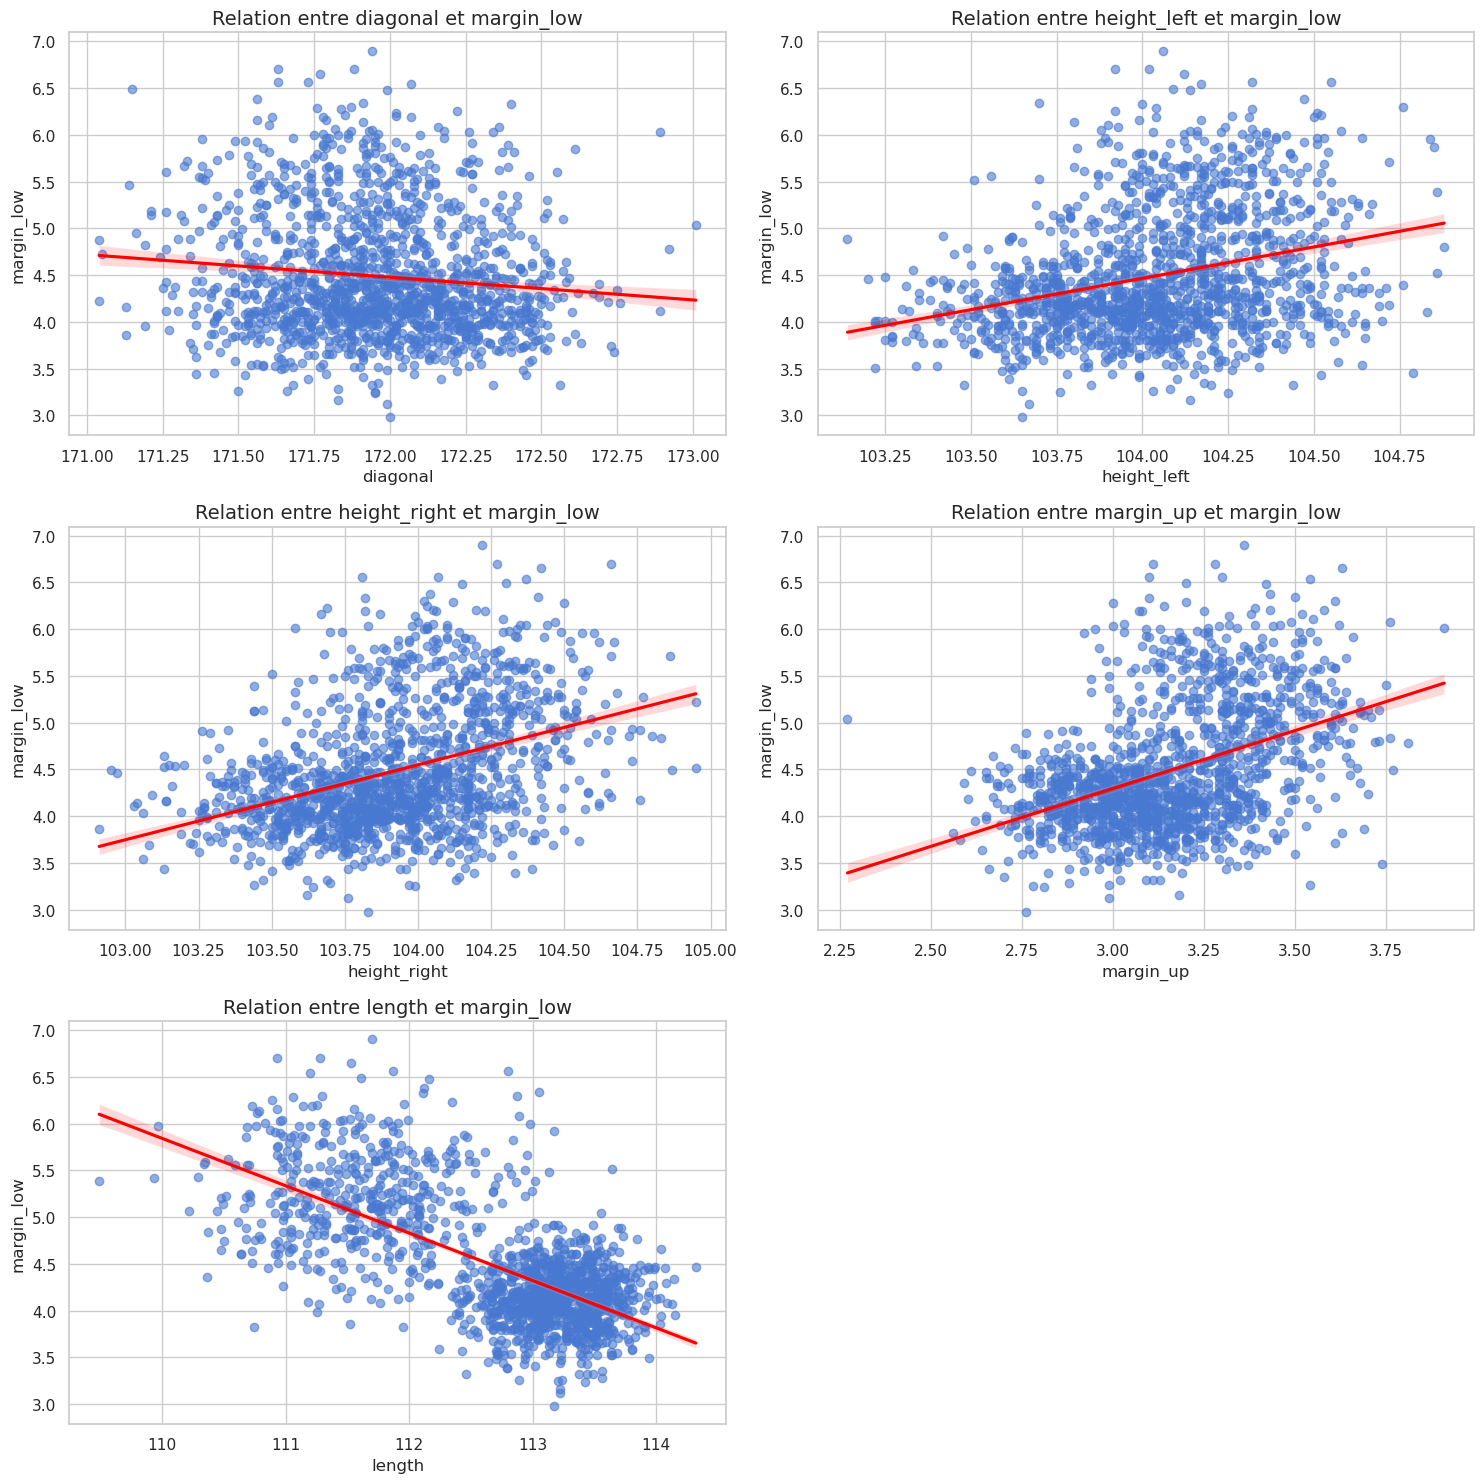

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Paramètres de style pour améliorer l'apparence
sns.set(style="whitegrid", palette="muted")

# Tracer les relations entre chaque variable indépendante et la variable dépendante
independent_vars = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

# Configuration de la figure pour afficher des graphiques côte à côte
num_cols = 2
num_rows = (len(independent_vars) + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Parcours des variables indépendantes et affichage des graphiques
for i, var in enumerate(independent_vars):
    row = i // num_cols
    col_idx = i % num_cols
    ax = axes[row, col_idx]
    
    # Affichage du nuage de points avec ligne de régression
    sns.regplot(x=billets[var], y=billets['margin_low'], ax=ax, color='b', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('margin_low', fontsize=12)
    ax.set_title(f'Relation entre {var} et margin_low', fontsize=14)

# Supprimer les axes vides si le nombre de graphiques est impair
if len(independent_vars) % num_cols != 0:
    fig.delaxes(axes[num_rows-1, num_cols-1])

# Ajustement des espaces entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure
plt.show()

### 11. Comparaison des modèles
Nous comparons les performances des deux modèles pour déterminer lequel est le meilleur.

In [36]:
# Comparaison des modèles
print("Comparaison des modèles:")
print("Régression Linéaire Simple - MSE:", mse_simple, "R²:", r2_simple)
print("Régression Linéaire Multiple - MSE:", mse_mult, "R²:", r2_mult)

if r2_mult > r2_simple:
    print("Le modèle de Régression Linéaire Multiple est meilleur.")
else:
    print("Le modèle de Régression Linéaire Simple est meilleur.")

Comparaison des modèles:
Régression Linéaire Simple - MSE: 0.20501721543154167 R²: 0.5136070700267941
Régression Linéaire Multiple - MSE: 0.19144954947493598 R²: 0.5457956683532343
Le modèle de Régression Linéaire Multiple est meilleur.


### 12. Affichage des premiers enregistrements des données complètes
Nous affichons les premiers enregistrements des données complètes après la prédiction des valeurs manquantes

In [37]:
# Affichage des premiers enregistrements des données complètes
display(billets_complete.head())

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [38]:
# Vérification des valeurs manquantes
print(billets_complete.isnull().sum())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [39]:
# billets_complete.to_csv("RESULTATS/billets_complete.csv", index=False,encoding='utf-8-sig')